In [1]:
%load_ext dotenv
%dotenv ../../05_src/.secrets

# Introduction to LangGraph

LangGraph is a low-level agent orchestration framework. It integrates with LangChain, but can also operate without it. 

We will build a graph to demonstrate how LangGraph integrates different models and tools.

There are six steps in this demo which is roughly based on [LangGraph's Quickstart](https://docs.langchain.com/oss/python/langgraph/quickstart):

1. Define tools and models
2. Define state
3. Define model node
4. Deine tool node
5. Define end logic
6. Build and compile the agent

# Define tools and model

We will use an OpenAI model and a tools that query public APIs to illustrate tools usage. 

The APIs are:
- [Meowfacts API](https://github.com/wh-iterabb-it/meowfacts)
- [Dog Facts API](https://kinduff.github.io/dog-api/)

Start by initializing a [chat model](https://docs.langchain.com/oss/python/langchain/models#initialize-a-model) in LangChain. 

In [2]:
from langchain.chat_models import init_chat_model
import os

model = init_chat_model(
    "openai:gpt-4o-mini",
    temperature=0.7,
    base_url='https://k7uffyg03f.execute-api.us-east-1.amazonaws.com/prod/openai/v1', 
    api_key='any value',
    default_headers={"x-api-key": os.getenv('API_GATEWAY_KEY')}
)

The model component can directly be used, however we will make it part of a larger object called a Graph.

In [3]:
response = model.invoke("Why do parrots talk?")

In [4]:
response.to_json()

{'lc': 1,
 'type': 'constructor',
 'id': ['langchain', 'schema', 'messages', 'AIMessage'],
 'kwargs': {'content': "Parrots talk primarily as a means of communication, both in the wild and in captivity. Here are some reasons why parrots are known for their ability to mimic human speech:\n\n1. **Social Creatures**: Parrots are highly social birds and use vocalizations to communicate with their flock. Mimicking sounds, including human speech, helps them bond with their social group, whether it's other birds or humans.\n\n2. **Mimicry Skills**: Parrots have a remarkable ability to mimic sounds they hear in their environment. This skill is a natural adaptation that helps them integrate into their surroundings and communicate effectively with others.\n\n3. **Attention-Seeking**: In captivity, parrots may learn to talk as a way to gain attention from their owners. They often repeat words or phrases that elicit a response, reinforcing the behavior.\n\n4. **Cognitive Abilities**: Parrots are in

Using LangChain, define tools. Notice the `@tool` decorator on each key function definition.

In [5]:
from langchain.tools import tool
import requests
import json

@tool
def get_cat_facts(n:int=1):
    """
    Returns n cat facts from the Meowfacts API.
    """
    url = "https://meowfacts.herokuapp.com/"
    params = {
        "count": n
    }
    response = requests.get(url, params=params)
    resp_dict = json.loads(response.text)
    facts_list = resp_dict.get("data", [])
    facts = "\n".join([f"{i+1}. {fact}\n" for i, fact in enumerate(facts_list)])
    return facts

@tool
def get_dog_facts(n:int=1):
    """
    Returns n dog facts from the Dog API.
    """
    url = "http://dogapi.dog/api/v2/facts"
    params = {
        "limit": n
    }
    response = requests.get(url, params=params)
    resp_dict = json.loads(response.text)
    facts_list = resp_dict.get("data", [])
    facts = "\n".join([f"{i+1}. {fact['attributes']['body']}\n" for i, fact in enumerate(facts_list)])
    return facts


# Augment the LLM with tools
tools = [get_cat_facts, get_dog_facts]
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)

# Define state

The graph's state is used to store:

+ The message history.
+ The number of LLM calls.

This is an extension of `langgraph.MessagesState`, which does not store the number of LLM calls. The [`Annotated`](https://docs.python.org/3/library/typing.html#typing.Annotated) type with [`operator.add`](https://docs.python.org/3/library/operator.html#module-operator) ensures that new messages are appended to the existing list rather than replacing it.

In [6]:
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator


class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int

# Define Model Node

The model node is used to call the LLM and decide wheter to call the tool or not.

In [7]:
from langchain_core.messages import SystemMessage


def llm_call(state: dict):
    """LLM decides whether to call a tool or not"""
    return {
        "messages": [
            model_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with stating interesting and fun facts about cats and dogs."
                    )
                ]
                + state["messages"]
            )
        ],
        "llm_calls": state.get('llm_calls', 0) + 1
    }

# Define Tool Node

The tool node is used to call the tools and return the results.

In [8]:
from langchain_core.messages import ToolMessage


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

# Define End Logic

The conditional edge function is used to route to the tool node or end based upon whether the LLM made a tool call.

In [9]:
from typing import Literal
from langgraph.graph import StateGraph, START, END


def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we stop (reply to the user)
    return END

# Build and Compile the Agent

The agent is built using the [`StateGraph`](https://reference.langchain.com/python/langgraph/graphs/?_gl=1*z2scpt*_gcl_au*MTczODQwMTgwNC4xNzU5MjU2OTcw*_ga*NDE4MTM5NDc2LjE3NTkyNTY5NzA.*_ga_47WX3HKKY2*czE3NjE0MjEyMDQkbzMyJGcxJHQxNzYxNDI0MTcxJGoxOCRsMCRoMA..#langgraph.graph.state.StateGraph) class and compiled using the [`compile`](https://reference.langchain.com/python/langgraph/graphs/?_gl=1*1dnnqxy*_gcl_au*MTczODQwMTgwNC4xNzU5MjU2OTcw*_ga*NDE4MTM5NDc2LjE3NTkyNTY5NzA.*_ga_47WX3HKKY2*czE3NjE0MjkwMjUkbzMzJGcwJHQxNzYxNDI5MDI1JGo2MCRsMCRoMA..#langgraph.graph.state.StateGraph.compile) method.

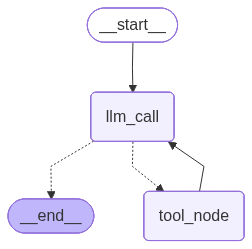

In [10]:
# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
from IPython.display import Image, display
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))



We can run the model as follows:

In [11]:
# Invoke
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Tell me 3 things about cats."), HumanMessage(content="Now tell me 2 things about dogs.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Tell me 3 things about cats.
================================ Human Message =================================

Now tell me 2 things about dogs.
================================== Ai Message ==================================
Tool Calls:
  get_cat_facts (call_3IDXI2MeUfsHiPSF5oYBN9XI)
 Call ID: call_3IDXI2MeUfsHiPSF5oYBN9XI
  Args:
    n: 3
  get_dog_facts (call_gfydwnw5Sb9L3NtB8zjjQY9x)
 Call ID: call_gfydwnw5Sb9L3NtB8zjjQY9x
  Args:
    n: 2
================================= Tool Message =================================

1. The way you treat kittens in the early stages of it's life will render it's personality traits later in life.

2. Baking chocolate is the most dangerous chocolate to your cat.

3. Cats, especially older cats, do get cancer. Many times this disease can be treated successfully.

================================= Tool Message =================================

1. Two stray dogs in Afgha